In [1]:
### Base ###
import os
import numpy as np 
import torch 
import torch.nn as nn
from torch.optim import Adam
import fnmatch
from torch.utils.data import TensorDataset, DataLoader
import itertools
import math
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
import PIL.Image as pimg

### Visualization ###
#import seaborn as sns
#sns.set(color_codes=True)
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family':'serif','serif':['Palatino']})

40.36492651796569 40.36492651796569


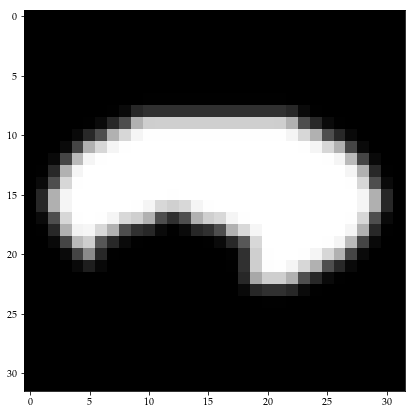

In [2]:
img_size = 32

dx = 0.7
dy = 1.3
# dx = 1.
# dy = 1.

brain_r = 30
tumour_r = 15

tumour_pr = 20.
# for t in [0.0, 0.25, 0.5, 0.75, 1., 1.25, 1.5, 1.75, 2.0]:
tumour_pt = 0.66 * math.pi

tumour_x = 50. + tumour_pr * math.cos(tumour_pt)
tumour_y = 50. + tumour_pr * math.sin(tumour_pt)
print(tumour_x, tumour_x)

tumour_c = 0.

sigma = 2.0

img = np.zeros((img_size, img_size))
coordinates_x, coordinates_y = np.meshgrid(np.arange(1, img_size + 1), np.arange(1, img_size + 1))

center = (img_size + 1.) / 2.0
img[((coordinates_x - center) ** 2) / (brain_r / dx * img_size / 100.) ** 2 + ((coordinates_y - center) ** 2) / (brain_r / dy * img_size / 100.) ** 2 <= 1.] = 1.0
img[((coordinates_x - tumour_x * img_size / 100.) ** 2) / (tumour_r / dx * img_size / 100.) ** 2 + ((coordinates_y - tumour_y * img_size / 100.) ** 2) / (tumour_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_c
img = gaussian_filter(img, sigma * img_size / 100.)

figsize = 7
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(img, cmap='gray')
# plt.scatter(center, center)
plt.show()

In [3]:
np.linspace(0.75, 1.25, 11, endpoint=True), np.linspace(0.725, 1.275, 12, endpoint=True)

(array([0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25]),
 array([0.725, 0.775, 0.825, 0.875, 0.925, 0.975, 1.025, 1.075, 1.125,
        1.175, 1.225, 1.275]))

In [4]:
np.linspace(0.75, 1.25, 6, endpoint=True), np.linspace(0.7, 1.3, 7, endpoint=True)

(array([0.75, 0.85, 0.95, 1.05, 1.15, 1.25]),
 array([0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3]))

In [5]:
np.linspace(0.05, 0.95, 10, endpoint=True), np.linspace(0., 1., 10, endpoint=False)

(array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

In [6]:
np.linspace(0.0, 1.0, 6, endpoint=False), np.linspace(1./12., 1.+1./12., 6, endpoint=False)

(array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333]),
 array([0.08333333, 0.25      , 0.41666667, 0.58333333, 0.75      ,
        0.91666667]))

In [7]:
np.linspace(0.0, 1.0, 10, endpoint=False), np.linspace(1./20., 1.+1./20., 10, endpoint=False)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]))

In [8]:
np.linspace(10, 20, 6), np.linspace(9, 21, 7)

(array([10., 12., 14., 16., 18., 20.]),
 array([ 9., 11., 13., 15., 17., 19., 21.]))

In [9]:
np.linspace(2.5, 17.5, 6), np.linspace(1, 19, 7)

(array([ 2.5,  5.5,  8.5, 11.5, 14.5, 17.5]),
 array([ 1.,  4.,  7., 10., 13., 16., 19.]))

In [10]:
np.linspace(3, 10.5, 6), np.linspace(2.25, 11.25, 7)

(array([ 3. ,  4.5,  6. ,  7.5,  9. , 10.5]),
 array([ 2.25,  3.75,  5.25,  6.75,  8.25,  9.75, 11.25]))

In [11]:
np.linspace(3, 18, 6), np.linspace(1.5, 19.5, 7)

(array([ 3.,  6.,  9., 12., 15., 18.]),
 array([ 1.5,  4.5,  7.5, 10.5, 13.5, 16.5, 19.5]))

In [12]:
np.linspace(9, 18, 4), np.linspace(7.5, 19.5, 5)

(array([ 9., 12., 15., 18.]), array([ 7.5, 10.5, 13.5, 16.5, 19.5]))

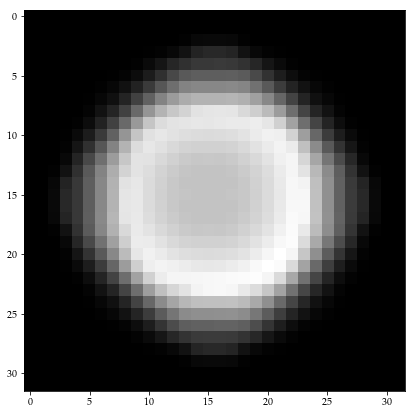

In [13]:
# Generate data

# TRAIN
path_to_folder = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_final/train_32__1440_denser'

if not os.path.isdir(path_to_folder):
    os.mkdir(path_to_folder)

img_size = 32
center = (img_size + 1.) / 2.0
    
average = np.zeros((img_size, img_size))

k = 0
for dx in np.linspace(0.75, 1.25, 6, endpoint=True): 
    for dy in np.linspace(0.75, 1.25, 6, endpoint=True): 
#        for pt in np.linspace(0.0, 1.0, 6, endpoint=False): 
        for pt in np.linspace(0.0, 1.0, 10, endpoint=False): 
#            for r in np.linspace(10, 20, 6):
#            for r in np.linspace(2.5, 17.5, 6):
#            for r in np.linspace(3, 18, 6):
            for r in np.linspace(9, 18, 4):
#            for r in np.linspace(3, 10.5, 6):

                brain_r = 30
                tumour_r = r 

                tumour_pr = 15.
                tumour_pt = pt * 2. * math.pi

                tumour_x = 50. + tumour_pr * math.cos(tumour_pt)
                tumour_y = 50. + tumour_pr * math.sin(tumour_pt)

                tumour_c = 0.

                sigma = 2.0

                img = np.zeros((img_size, img_size))
                coordinates_x, coordinates_y = np.meshgrid(np.arange(1, img_size + 1), np.arange(1, img_size + 1))

                center = (img_size + 1.) / 2.0
                img[((coordinates_x - center) ** 2) / (brain_r / dx * img_size / 100.) ** 2 + ((coordinates_y - center) ** 2) / (brain_r / dy * img_size / 100.) ** 2 <= 1.] = 1.0
                img[((coordinates_x - tumour_x * img_size / 100.) ** 2) / (tumour_r / dx * img_size / 100.) ** 2 + ((coordinates_y - tumour_y * img_size / 100.) ** 2) / (tumour_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_c
                img = gaussian_filter(img, sigma * img_size / 100.)

                tol = 1e-10
                img = (np.clip(img, tol, 1.0 - tol) * 255).astype('uint8')
                pimg.fromarray(img).save(os.path.join(path_to_folder, 'eye__%d.png' % k))

                average += img
                k += 1
average /= float(k)

figsize = 7
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(average, cmap='gray')
plt.show()

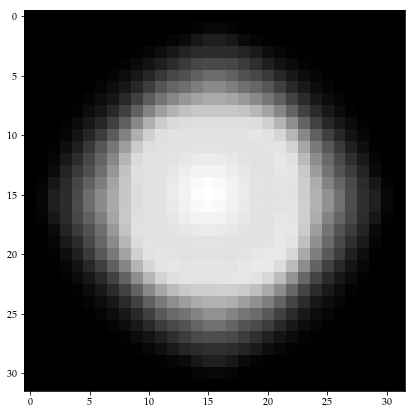

In [14]:
# Generate data

# TEST
path_to_folder = '/Users/alexandre.bone/Softwares/deepshape/examples/eyes/data_final/test_32__1440_denser'

if not os.path.isdir(path_to_folder):
    os.mkdir(path_to_folder)

img_size = 32
center = (img_size + 1.) / 2.0
    
average = np.zeros((img_size, img_size))

k = 0
for dx in np.linspace(0.7, 1.3, 7, endpoint=True): 
    for dy in np.linspace(0.7, 1.3, 7, endpoint=True): 
#        for pt in np.linspace(1./12., 1.+1./12., 6, endpoint=False): 
#        for pt in np.linspace(0., 1., 10, endpoint=False): 
        for pt in np.linspace(1./20., 1.+1./20., 10, endpoint=False): 
#            for r in np.linspace(9, 21, 7):
#            for r in np.linspace(1, 19, 7):
#            for r in np.linspace(1.5, 19.5, 7):
            for r in np.linspace(7.5, 19.5, 5):
#            for r in np.linspace(2.25, 11.25, 7):

                brain_r = 30
                tumour_r = r

                tumour_pr = 20.
                tumour_pt = pt * 2. * math.pi

                tumour_x = 50. + tumour_pr * math.cos(tumour_pt)
                tumour_y = 50. + tumour_pr * math.sin(tumour_pt)

                tumour_c = 0.

                sigma = 2.0

                img = np.zeros((img_size, img_size))
                coordinates_x, coordinates_y = np.meshgrid(np.arange(1, img_size + 1), np.arange(1, img_size + 1))

                center = (img_size + 1.) / 2.0
                img[((coordinates_x - center) ** 2) / (brain_r / dx * img_size / 100.) ** 2 + ((coordinates_y - center) ** 2) / (brain_r / dy * img_size / 100.) ** 2 <= 1.] = 1.0
                img[((coordinates_x - tumour_x * img_size / 100.) ** 2) / (tumour_r / dx * img_size / 100.) ** 2 + ((coordinates_y - tumour_y * img_size / 100.) ** 2) / (tumour_r / dy * img_size / 100.) ** 2 <= 1.] = tumour_c
                img = gaussian_filter(img, sigma * img_size / 100.)

                tol = 1e-10
                img = (np.clip(img, tol, 1.0 - tol) * 255).astype('uint8')
                pimg.fromarray(img).save(os.path.join(path_to_folder, 'eye__%d.png' % k))

                average += img
                k += 1
average /= float(k)

figsize = 7
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(average, cmap='gray')
plt.show()